In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# 表示の幅を広げる
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
rcParams['figure.figsize'] = 10, 10 # グラフが見きれないようにするためサイズを大きくしておく

## "kaitori"内の姓名(カナ)が半角なのでそれを全角に変える
#### カナを軸に結合するため修正が必要

In [2]:
# Gitから日本語変換できるライブラリをインストール
!python3.8 -m pip install --upgrade pip
!pip install jaconv
import jaconv

In [29]:
df0 = pd.read_csv('出張買取実績_20200819以前.csv', low_memory=False)

In [94]:
# 一旦、dictにいれる
L = []
for i in df0['姓名（カナ）']:
    a = jaconv.h2z(i)
    L.append(a)

#'カナ'というカラムを一旦作る
df0['カナ'] = '名前'
df0.head()

for i in range(len(L)):
   df0['カナ'][i] = L[i]

<ipython-input-94-4f9db7856455>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['カナ'][i] = L[i]


In [4]:
# 住所・市町村のカラム内で欠損している行を削除して、df1にいれる
df0 = df0.dropna(subset=['都道府県','住所1'])

In [5]:
# 東京都とそれ以外で分ける
data_tokyo = df0[df0['都道府県'].str.contains('東京都')]
data1 = data_tokyo[data_tokyo['住所1'].str.contains('区')] #東京23区を抽出
data_others = df0[~df0['住所1'].str.contains('区')] #東京23区以外を抽出

# 東京都23区について
# 区で分けて、それを元のdfにいれる
new = data1['住所1'] .str.split("区", n = 1, expand = True) 
new[0] = new[0]+"区"
data1['住所1'] = new[0]
data1['住所2'] = new[1]

# 必要な情報のみを抽出
on = ['点数', '金額','住所1']
data2 = data1[on]
data3 = data2.groupby('住所1').sum()
df3 = pd.DataFrame(data3)

<ipython-input-5-bdf05ff03c7d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['住所1'] = new[0]
<ipython-input-5-bdf05ff03c7d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['住所2'] = new[1]


# 住宅情報(2015年)

In [6]:
!pip install mojimoji
import mojimoji

In [7]:
kokuzei0 = pd.read_csv('2015国政調査・小地域集計.csv', low_memory=False)
kokuzei0 = kokuzei0[kokuzei0["市区町村名"].str.endswith('区')]
    
# "丁"を削除し数値のみにする
new = kokuzei0['字・丁目名'] .str.split("丁", n = 1, expand = True) 

# 欠損値を0に置換
new.fillna({0:0}, inplace=True) 
kokuzei0["字・丁目名"] = new[0]

# int型をstr型に変換し、全角数字を半角数字にする
kokuzei0['字・丁目名'] = kokuzei0['字・丁目名'].astype('str')
kokuzei0['字・丁目名'] = kokuzei0["字・丁目名"].apply(mojimoji.zen_to_han)
# 必要な項目のみ抽出
on = ["都道府県名","市区町村名","大字・町名","字・丁目名","一般世帯総数（住居の種類・住宅の所有の関係）","住宅に住む一般世帯","主世帯","持ち家",
      "民営の借家","給与住宅","住宅に住む一般世帯.1","主世帯.1","持ち家.1"]
kokuzei2 = kokuzei0[on]

In [8]:
kokuzei2[kokuzei2["市区町村名"] == "渋谷区"].head()

,都道府県名,市区町村名,大字・町名,字・丁目名,一般世帯総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯,主世帯,持ち家,民営の借家,給与住宅,住宅に住む一般世帯.1,主世帯.1,持ち家.1
2031,東京都,渋谷区,NaN,0,135520,133540,131894,55856,68024,4804,219888,217194,111550
2032,東京都,渋谷区,恵比寿,0,9936,9772,9685,3931,5468,277,15144,14997,7502
2033,東京都,渋谷区,恵比寿,1,2471,2465,2439,985,1398,56,3736,3701,1823
2034,東京都,渋谷区,恵比寿,2,2817,2707,2690,1038,1575,77,4182,4146,1949
2035,東京都,渋谷区,恵比寿,3,2769,2751,2715,1124,1503,79,4397,4331,2338


# 世帯所得情報（2015）

In [9]:
TYO_income = pd.read_csv('東京都世帯収入2015.csv', low_memory=False) #from e-stat
TYO_income.rename(columns={'市区町村':'市区町村名'}, inplace = True) #ラベル名変更

In [10]:
TYO_income.head()

,ID,県,市区町村名,普通世帯総数,25歳未満,25〜34歳,35〜44,45〜54,55〜64,65歳以上,自営業主,農林・漁業業主,商工・その他の業主,雇用者,会社・団体・公社又は個人に雇われている者,官公庁,労働者派遣事業所の派遣社員,パート・アルバイト・その他,無職,学生,その他,300万円未満,300〜500,500〜700,700〜1000,1000万円以上
0,100,東京都,特別区部,4613570,160940,548720,736050,712320,649570,1240920,370710,2920,367790,1494560,1102490,83290,57170,251610,623290,36500,586790,1336500,1105980,664560,521910,439290
1,101,東京都,千代田区,27590,530,4640,4720,4610,4460,6850,3050,0,3050,8390,5370,2400,130,480,2370,210,2160,3540,5290,5950,4910,6170
2,102,東京都,中央区,76170,2170,13110,16270,15270,10320,15060,6390,60,6340,27950,23600,1320,630,2400,6370,210,6170,13750,17490,13430,12460,15320
3,103,東京都,港区,111380,2150,12950,21420,18260,15280,28870,7850,70,7780,23040,18220,1400,480,2940,8340,340,8010,18700,19050,15420,19660,26310
4,104,東京都,新宿区,195350,11590,24890,31780,28620,23600,48750,12050,120,11930,46460,32660,4750,1360,7690,22760,2460,20300,57820,43440,27350,21100,21120


# 高級住宅街のリスト

In [11]:
dff = pd.read_csv('エリア(区)ごとの買取総額 - 高級持ち家エリア.csv', low_memory=False)
dff["市区町村名"] = dff["市区町村名"] + "区"

# 必要な要素のみ抽出
on = ["市区町村名","大字・町名","字・丁目名"]
rich_nbhd = dff[on]

# 欠損値の補完
rich_nbhd.fillna({'字・丁目名':0}, inplace=True)
rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(int)
rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(str)

/Users/satoshiido/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-11-a0caf7eb995d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rich_nbhd["字・丁目名"] = rich_nbhd["字・丁目名"].astype(int)
<ipython-input-11-a0caf7eb995d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

# 各dfを結合させる 

In [12]:
df0 = pd.merge(rich_nbhd, TYO_income, on='市区町村名', how='left')
df1 = pd.merge(df0, kokuzei2, on = ["市区町村名", "大字・町名", "字・丁目名"], how='left')

## 必要な情報を追加する

In [13]:
# 55才以上の割合
df1['65才以上の割合'] = df1["65歳以上"] / df1["普通世帯総数"]
df1['45~64才の割合']  = (df1["55〜64"] + df1["45〜54"]) / df1["普通世帯総数"]

# 1000万以上の割合
df1['1000万以上の割合'] = df1["1000万円以上"] / (df1["300万円未満"]+df1["300〜500"]+df1["500〜700"]+df1["1000万円以上"])

# 持ち家比率を計算（これが企業と個人で混在している可能性はある）
df1["主世帯"] = df1["主世帯"].astype(int)
df1["持ち家"] = df1["持ち家"].astype(int)
df1["持ち家比率"] = df1['持ち家'] / df1['主世帯']

# 自営業主比率を計算
df1['自営業主比率'] = df1['自営業主'] / (df1['自営業主']+df1['雇用者']+df1['無職']+df1['その他'])

df1[df1["大字・町名"] == "白金台"]
df1.head()

,市区町村名,大字・町名,字・丁目名,ID,県,普通世帯総数,25歳未満,25〜34歳,35〜44,45〜54,55〜64,65歳以上,自営業主,農林・漁業業主,商工・その他の業主,雇用者,会社・団体・公社又は個人に雇われている者,官公庁,労働者派遣事業所の派遣社員,パート・アルバイト・その他,無職,学生,その他,300万円未満,300〜500,500〜700,700〜1000,1000万円以上,都道府県名,一般世帯総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯,主世帯,持ち家,民営の借家,給与住宅,住宅に住む一般世帯.1,主世帯.1,持ち家.1,65才以上の割合,45~64才の割合,1000万以上の割合,持ち家比率,自営業主比率
0,品川区,東五反田,1,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1733,1723,1713,595,1065,53,2641,2623,1131,0.262896,0.28997,0.154773,0.347344,0.107203
1,品川区,東五反田,3,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1178,1173,1166,601,537,28,2088,2074,1309,0.262896,0.28997,0.154773,0.515437,0.107203
2,品川区,東五反田,4,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1385,1382,1371,648,615,108,2403,2382,1418,0.262896,0.28997,0.154773,0.472648,0.107203
3,品川区,東五反田,5,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1872,1705,1687,908,599,180,3105,3072,1894,0.262896,0.28997,0.154773,0.538234,0.107203
4,品川区,北品川,3,109,東京都,198710,6420,26790,37340,29030,28590,52240,15270,80,15190,73440,57820,2050,2660,10910,27270,800,26460,52130,47130,30550,28000,23770,東京都,1864,1819,1802,692,917,193,3439,3406,1473,0.262896,0.28997,0.154773,0.384018,0.107203


# 統計分析

In [18]:
from scipy import stats as ss
from scipy.stats import zscore

In [54]:
# 標準化
df1['45~64才の割合(標準化)'] = zscore(df1['45~64才の割合'])
df1['65才以上の割合(標準化)'] = zscore(df1['65才以上の割合'])
df1['1000万以上の割合(標準化)'] = zscore(df1['1000万以上の割合'])
df1['持ち家比率(標準化)'] = zscore(df1['持ち家比率'])
df1['自営業主比率(標準化)'] = zscore(df1['自営業主比率'])

# 分析に必要な要素のみ抽出
df2 = df1.iloc[:,[0,1,2,-5,-4,-3,-2,-1,]]
df2.head()

,市区町村名,大字・町名,字・丁目名,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化)
0,品川区,東五反田,1,0.4417,0.783892,-0.627095,-1.497389,-1.339928
1,品川区,東五反田,3,0.4417,0.783892,-0.627095,-0.069666,-1.339928
2,品川区,東五反田,4,0.4417,0.783892,-0.627095,-0.433105,-1.339928
3,品川区,東五反田,5,0.4417,0.783892,-0.627095,0.123956,-1.339928
4,品川区,北品川,3,0.4417,0.783892,-0.627095,-1.185894,-1.339928


In [55]:
df3 = df1.iloc[:,[-5,-4,-3,-2,-1]]
df3.head()

,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化)
0,0.4417,0.783892,-0.627095,-1.497389,-1.339928
1,0.4417,0.783892,-0.627095,-0.069666,-1.339928
2,0.4417,0.783892,-0.627095,-0.433105,-1.339928
3,0.4417,0.783892,-0.627095,0.123956,-1.339928
4,0.4417,0.783892,-0.627095,-1.185894,-1.339928


### 可視化

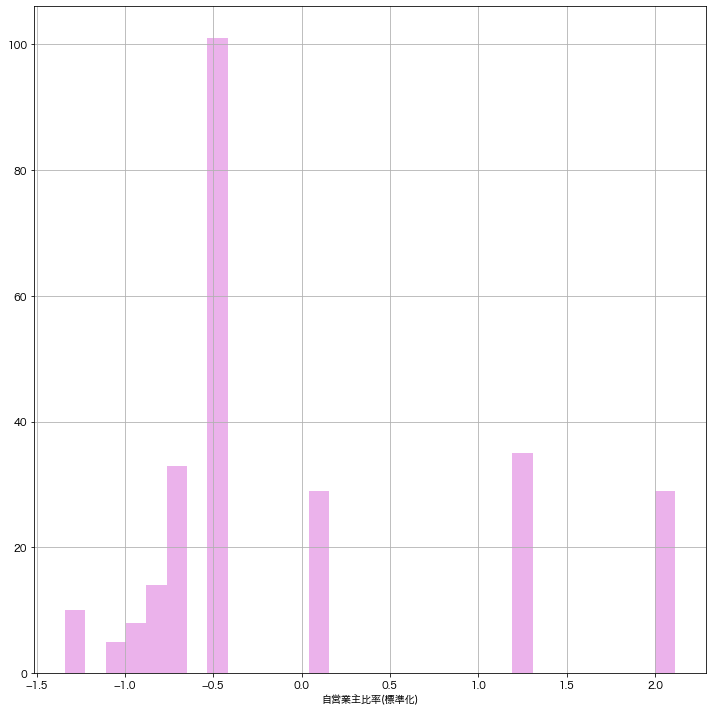

Text(0, 0.5, 'エリア累数')

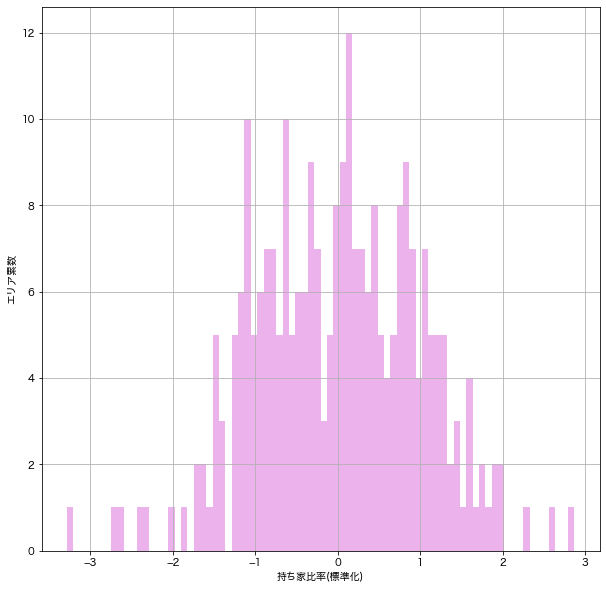

In [56]:
import matplotlib as mpl
import matplotlib.font_manager
mpl.rcParams['font.family'] = 'Hiragino Sans'

fig = plt.figure()
df1['自営業主比率(標準化)'].hist(bins=30,alpha=0.3, histtype='stepfilled', color='m', label='A')
plt.xlabel("自営業主比率(標準化)")
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show() # グラフの表示

df1['持ち家比率(標準化)'].hist(bins=80,alpha=0.3, histtype='stepfilled', color='m', label='A')
plt.xlabel("持ち家比率(標準化)")
plt.ylabel("エリア累数")


## クラスタリング

In [61]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(df3)
df2['クラスター番号'] = clusters.labels_
print(df2['クラスター番号'].unique())
df2.head()

[0 1 2 3 4]


<ipython-input-61-9f82f4f4a3e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['クラスター番号'] = clusters.labels_


,市区町村名,大字・町名,字・丁目名,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化),クラスター番号
0,品川区,東五反田,1,0.4417,0.783892,-0.627095,-1.497389,-1.339928,0
1,品川区,東五反田,3,0.4417,0.783892,-0.627095,-0.069666,-1.339928,1
2,品川区,東五反田,4,0.4417,0.783892,-0.627095,-0.433105,-1.339928,1
3,品川区,東五反田,5,0.4417,0.783892,-0.627095,0.123956,-1.339928,1
4,品川区,北品川,3,0.4417,0.783892,-0.627095,-1.185894,-1.339928,0


In [62]:
df2.groupby('クラスター番号').mean() #各クラスターごとの特徴

,45~64才の割合(標準化),65才以上の割合(標準化),1000万以上の割合(標準化),持ち家比率(標準化),自営業主比率(標準化)
クラスター番号,,,,,
0,-0.510359,0.480274,-1.017361,-0.794535,-0.687243
1,0.524945,0.574721,-0.234684,0.068838,-0.472573
2,0.964167,0.620660,2.245355,0.477227,1.275370
3,1.397184,0.422794,0.063929,-0.109960,2.113237
4,-1.151952,-1.527899,-0.002271,0.467527,-0.441441


### クラスタリングの可視化

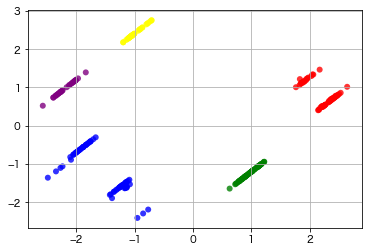

In [93]:
from sklearn.decomposition import PCA
X = df3
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["クラスター番号"] = df2['クラスター番号']

import matplotlib.pyplot as plt
%matplotlib inline
colors = ['red','blue','yellow','purple','green']
for i in df2['クラスター番号'].unique():
    tmp = pca_df.loc[pca_df["クラスター番号"] == i]
    plt.scatter(tmp[0],tmp[1],alpha=0.8, c=colors[i], edgecolors='none')
    plt.grid(True)